# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 3, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.25,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_56_drop0.25e500b512_custom/lnets_10000_280-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_3_d_5_sparsity_56_amin_-1_amax_1_xdist_uniform_noise_normal_0.25
lnets_10000_280-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_3_d_5_sparsity_56_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.25


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/216 [00:00<?, ?it/s]

List length: 216
Number of monomials in a polynomial with 3 variables and degree 5: 56
Sparsity: 56
['000', '001', '002', '003', '004', '005', '010', '011', '012', '013', '014', '015', '020', '021', '022', '023', '024', '025', '030', '031', '032', '033', '034', '035', '040', '041', '042', '043', '044', '045', '050', '051', '052', '053', '054', '055', '100', '101', '102', '103', '104', '105', '110', '111', '112', '113', '114', '115', '120', '121', '122', '123', '124', '125', '130', '131', '132', '133', '134', '135', '140', '141', '142', '143', '144', '145', '150', '151', '152', '153', '154', '155', '200', '201', '202', '203', '204', '205', '210', '211', '212', '213', '214', '215', '220', '221', '222', '223', '224', '225', '230', '231', '232', '233', '234', '235', '240', '241', '242', '243', '244', '245', '250', '251', '252', '253', '254', '255', '300', '301', '302', '303', '304', '305', '310', '311', '312', '313', '314', '315', '320', '321', '322', '323', '324', '325', '330', '331', '33

  0%|          | 0/216 [00:00<?, ?it/s]

List length: 56
Number of monomials in a polynomial with 3 variables and degree 5: 56
Sparsity: 56
['000', '001', '002', '003', '004', '005', '010', '011', '012', '013', '014', '020', '021', '022', '023', '030', '031', '032', '040', '041', '050', '100', '101', '102', '103', '104', '110', '111', '112', '113', '120', '121', '122', '130', '131', '140', '200', '201', '202', '203', '210', '211', '212', '220', '221', '230', '300', '301', '302', '310', '311', '320', '400', '401', '410', '500']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:  5.6min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 1570)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 1570)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 1570)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

## Interpretation Network Training

In [21]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 50 Complete [00h 41m 46s]
val_loss: 0.3512698709964752

Best val_loss So Far: 0.10071482509374619
Total elapsed time: 11h 29m 19s
Epoch 1/500
254/254 [==============================] - 5s 21ms/step - loss: 0.5025 - val_loss: 0.2922
Epoch 2/500
254/254 [==============================] - 5s 20ms/step - loss: 0.2896 - val_loss: 0.2437
Epoch 3/500
254/254 [==============================] - 5s 19ms/step - loss: 0.2561 - val_loss: 0.2204
Epoch 4/500
254/254 [==============================] - 5s 20ms/step - loss: 0.2363 - val_loss: 0.2047
Epoch 5/500
254/254 [==============================] - 5s 20ms/step - loss: 0.2202 - val_loss: 0.1942
Epoch 6/500
254/254 [==============================] - 5s 20ms/step - loss: 0.2096 - val_loss: 0.1851
Epoch 7/500
254/254 [==============================] - 5s 20ms/step - loss: 0.2011 - val_loss: 0.1777
Epoch 8/500
254/254 [==============================] - 5s 19ms/step - loss: 0.1938 - val_loss: 0.1720
Epoch 9/500
254/254 [===========================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 741.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 741.5min finished


## Evaluate Interpretation Net

In [22]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.25
dense_block_1/units_1: 128
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 2e-05
dense_block_1/units_2: 512
Score: 0.10071482509374619
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.25
dense_block_1/units_1: 128
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 2e-05
dense_block_1/units_2: 64
Score: 0.10087762027978897
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.25
dense_block_1/units_1: 128
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 1e-05
dense_block_1/units_2: 64
Score: 0.10292048752307892
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers

In [23]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1401)]            0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 1401)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1435648   
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 1457)              1493425   
Total params: 2,929,073
Trainable params: 2,929,073
Non-trainable params: 0
____________________________________________

In [24]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.483,0.586,13.801,0.061,0.000,0.120,0.163,0.963,0.928,0.179,0.635,0.143,-0.032,0.019,1.328,1.351
inetPoly_VS_targetPoly_test,0.485,0.588,11.895,0.061,0.000,0.121,0.163,1.115,0.937,0.172,0.628,0.145,-0.031,0.015,1.327,1.349
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.104,0.130,0.796,0.957,0.151,0.342,0.108,-0.032,0.018,1.328,1.335
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.104,0.130,0.721,0.962,0.145,0.333,0.109,-0.031,0.015,1.327,1.332
inetPoly_VS_lstsqTarget_valid,4.591,7.589,93.844,0.018,0.000,0.103,0.129,0.796,0.958,0.149,0.371,0.107,-0.032,0.018,1.328,1.335
inetPoly_VS_lstsqTarget_test,4.717,7.890,89.656,0.017,0.000,0.103,0.129,0.743,0.963,0.143,0.353,0.108,-0.031,0.015,1.327,1.332
inetPoly_VS_lstsqLambda_valid,4.591,7.589,93.844,0.018,0.000,0.103,0.129,0.796,0.958,0.149,0.371,0.107,-0.032,0.018,1.328,1.335
inetPoly_VS_lstsqLambda_test,4.717,7.890,89.656,0.017,0.000,0.103,0.129,0.743,0.963,0.143,0.353,0.108,-0.031,0.015,1.327,1.332
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.019,0.025,0.138,0.999,0.027,0.128,0.025,0.018,0.018,1.335,1.335
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.019,0.025,0.214,0.999,0.026,0.131,0.025,0.015,0.015,1.332,1.332


In [25]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.146,0.102,0.138,0.117,0.086,0.102,0.168,0.104,0.169,0.156,0.095,0.119,0.127,0.106,0.122,0.100,0.098,0.133,0.080,0.099,0.108,0.078,0.130,0.172,0.078,0.108,0.108,0.200,0.132,0.085,0.077,0.083,0.139,0.169,0.088,0.083,0.077,0.101,0.099,0.140,0.114,0.091,0.098,0.095,0.096,0.134,0.098,0.124,0.109,0.199,0.141,0.113,0.103,0.094,0.090,0.149,0.105,0.114,0.167,0.097,0.105,0.134,0.092,0.311,0.101,0.117,0.099,0.104,0.123,0.084,0.132,0.143,0.185,0.129,0.117,0.060,0.075,0.165,0.170,0.080,0.102,0.165,0.100,0.152,0.099,0.101,0.112,0.113,0.115,0.114,0.119,0.087,0.124,0.106,0.134,0.128,0.174,0.110,0.122,0.083,0.096,0.099,0.103,0.105,0.078,0.153,0.115,0.116,0.102,0.087,0.125,0.154,0.106,0.129,0.085,0.121,0.065,0.074,0.093,0.107,0.119,0.135,0.090,0.167,0.147,0.084,0.163,0.140,0.116,0.219,0.119,0.171,0.093,0.085,0.159,0.101,0.099,0.217,0.096,0.128,0.180,0.078,0.107,0.158,0.129,0.076,0.159,0.125,0.156,0.114,0.107,0.116,0.118,0.136,0.171,0.197,0.080,0.110,0.147,0.122,0.139,0.133,0.088,0.118,0.080,0.122,0.109,0.128,0.119,0.136,0.205,0.093,0.159,0.109,0.128,0.118,0.112,0.141,0.113,0.

In [26]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.959,0.962,0.965,0.689,0.818,0.915,0.979,0.971,0.959,0.966,0.968,0.847,0.936,0.941,0.979,0.924,0.923,0.968,0.819,0.962,0.921,0.949,0.944,0.961,0.970,0.975,0.877,0.954,0.961,0.981,0.980,0.990,0.962,0.881,0.966,0.938,0.990,0.974,0.990,0.946,0.968,0.978,0.985,0.958,0.931,0.622,0.980,0.431,0.968,0.440,0.861,0.928,0.951,0.949,0.882,0.936,0.915,0.965,0.929,0.948,0.943,0.945,0.973,0.950,0.978,0.989,0.948,0.964,0.862,0.716,0.938,0.964,0.944,0.860,0.962,0.978,0.935,0.970,0.930,0.980,0.910,0.959,0.787,0.975,0.975,0.987,0.954,0.837,0.832,0.959,0.867,0.986,0.955,0.960,0.903,0.932,0.933,0.984,0.929,0.973,0.943,0.924,0.656,0.982,0.964,0.973,0.973,0.934,0.980,0.976,0.918,0.934,0.939,0.968,0.902,0.736,0.957,0.987,0.918,0.907,0.968,0.972,0.940,0.966,0.832,0.983,0.962,0.776,0.962,0.906,0.921,0.876,0.936,0.960,0.946,0.916,0.959,0.522,0.960,0.967,0.958,0.991,0.932,0.959,0.771,0.917,0.753,0.978,0.875,0.977,0.965,0.982,0.881,0.931,0.967,0.917,0.974,0.945,0.929,0.914,0.974,0.973,0.990,0.966,0.995,0.961,0.956,0.985,0.947,0.918,0.873,0.951,0.907,0.974,0.898,0.923,0.703,0.976,0.959,0.

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.9210977189150202


0.0822724550962448*a**1.0*b**1.0*c**1.0 + 0.0386596210300922*a**1.0*b**1.0*c**2.0 - 0.0974444523453712*a**1.0*b**1.0*c**3.0 + 0.595872402191162*a**1.0*b**1.0 + 0.0697290450334549*a**1.0*b**2.0*c**1.0 - 0.08011244982481*a**1.0*b**2.0*c**2.0 + 0.185136616230011*a**1.0*b**2.0 + 0.202016785740852*a**1.0*b**3.0*c**1.0 - 0.252008378505707*a**1.0*b**3.0 - 0.199412405490875*a**1.0*b**4.0 - 0.356330364942551*a**1.0*c**1.0 - 0.263617217540741*a**1.0*c**2.0 + 0.0090258065611124*a**1.0*c**3.0 + 0.00580410799011588*a**1.0*c**4.0 + 0.363149285316467*a**1.0 - 0.0647662654519081*a**2.0*b**1.0*c**1.0 - 0.348945587873459*a**2.0*b**1.0*c**2.0 + 0.264393776655197*a**2.0*b**1.0 + 0.0171540752053261*a**2.0*b**2.0*c**1.0 + 0.157166421413422*a**2.0*b**2.0 + 0.00691960193216801*a**2.0*b**3.0 - 0.279593765735626*a**2.0*c**1.0 - 0.131002947688103*a**2.0*c**2.0 - 0.0754113867878914*a**2.0*c**3.0 - 0.123403042554855*a**2.0 - 0.169329166412354*a**3.0*b**1.0*c**1.0 - 0.0423599518835545*a**3.0*b**1.0 + 0.010983665473

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9387820771027935


-1.62108579113333*a**1.0*b**1.0*c**1.0 - 9.01125810240686*a**1.0*b**1.0*c**2.0 + 7.07233433196278*a**1.0*b**1.0*c**3.0 + 1.10531877159656*a**1.0*b**1.0 + 5.37472234698278*a**1.0*b**2.0*c**1.0 - 1.38365446105578*a**1.0*b**2.0*c**2.0 + 4.86481066168207*a**1.0*b**2.0 + 5.86392528565983*a**1.0*b**3.0*c**1.0 - 9.50399157386754*a**1.0*b**3.0 + 0.0245356661274112*a**1.0*b**4.0 + 0.368754825469308*a**1.0*c**1.0 + 3.0775965625271*a**1.0*c**2.0 - 10.0885083003836*a**1.0*c**3.0 + 5.08265345992698*a**1.0*c**4.0 + 0.561546625845889*a**1.0 + 0.0880108559877905*a**2.0*b**1.0*c**1.0 - 1.05605631791376*a**2.0*b**1.0*c**2.0 + 0.564199447425467*a**2.0*b**1.0 - 8.93366237089795*a**2.0*b**2.0*c**1.0 + 2.14349032720855*a**2.0*b**2.0 + 5.39388331712757*a**2.0*b**3.0 + 0.971104980947956*a**2.0*c**1.0 + 7.58407994011255*a**2.0*c**2.0 - 3.68731515521431*a**2.0*c**3.0 - 4.0220446109895*a**2.0 + 4.24122073819916*a**3.0*b**1.0*c**1.0 - 2.36573627054383*a**3.0*b**1.0 - 2.85692728003663*a**3.0*b**2.0 - 6.68166661048

In [29]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.827576708224594*a**1.0*b**1.0*c**1.0 - 0.375245190515026*a**1.0*b**1.0*c**2.0 + 0.375490495260622*a**1.0*b**1.0*c**3.0 + 0.893770070098942*a**1.0*b**1.0 + 0.513598070606974*a**1.0*b**2.0*c**1.0 + 0.351948749901039*a**1.0*b**2.0*c**2.0 + 0.7371005102757*a**1.0*b**2.0 - 0.0566631909775341*a**1.0*b**3.0*c**1.0 - 0.626340850844563*a**1.0*b**3.0 - 0.283792725677453*a**1.0*b**4.0 + 0.624155878559548*a**1.0*c**1.0 + 0.408003535440812*a**1.0*c**2.0 + 0.356364652204877*a**1.0*c**3.0 - 0.992262203149633*a**1.0*c**4.0 - 0.398145251338872*a**1.0 - 0.694282146132135*a**2.0*b**1.0*c**1.0 - 0.880873179140925*a**2.0*b**1.0*c**2.0 + 0.340364543589194*a**2.0*b**1.0 - 0.0972124264714182*a**2.0*b**2.0*c**1.0 - 0.544983321643121*a**2.0*b**2.0 - 0.555101896993658*a**2.0*b**3.0 - 0.337033499366806*a**2.0*c**1.0 + 0.425060834040246*a**2.0*c**2.0 - 0.858324471030128*a**2.0*c**3.0 - 0.248891114409963*a**2.0 - 0.759032376417366*a**3.0*b**1.0*c**1.0 + 0.747318980319753*a**3.0*b**1.0 + 0.903792761016222*a**3.0*b

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.8720320133531274


-0.00410925410687923*a**1.0*b**1.0*c**1.0 + 0.339630454778671*a**1.0*b**1.0*c**2.0 - 0.17515803873539*a**1.0*b**1.0*c**3.0 + 0.639666378498077*a**1.0*b**1.0 + 0.0899092182517052*a**1.0*b**2.0*c**1.0 - 0.15374793112278*a**1.0*b**2.0*c**2.0 + 0.150353252887726*a**1.0*b**2.0 + 0.127925544977188*a**1.0*b**3.0*c**1.0 + 0.221964746713638*a**1.0*b**3.0 - 0.0276827644556761*a**1.0*b**4.0 + 0.518161118030548*a**1.0*c**1.0 + 0.362861752510071*a**1.0*c**2.0 + 0.166694447398186*a**1.0*c**3.0 - 0.114614628255367*a**1.0*c**4.0 + 1.13939940929413*a**1.0 + 0.175842851400375*a**2.0*b**1.0*c**1.0 - 0.103100940585136*a**2.0*b**1.0*c**2.0 + 0.0728278607130051*a**2.0*b**1.0 - 0.10204042494297*a**2.0*b**2.0*c**1.0 - 0.0130921779200435*a**2.0*b**2.0 - 0.226862818002701*a**2.0*b**3.0 + 0.0729002058506012*a**2.0*c**1.0 + 0.0715992227196693*a**2.0*c**2.0 - 0.145655691623688*a**2.0*c**3.0 + 0.570195734500885*a**2.0 - 0.0154732819646597*a**3.0*b**1.0*c**1.0 + 0.115766391158104*a**3.0*b**1.0 - 0.316131055355072*a*

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.8618872287356332


1.92220317043749*a**1.0*b**1.0*c**1.0 + 0.366173282316474*a**1.0*b**1.0*c**2.0 - 0.284303355513275*a**1.0*b**1.0*c**3.0 + 1.26142083267998*a**1.0*b**1.0 - 2.18591357291807*a**1.0*b**2.0*c**1.0 + 0.173689174730773*a**1.0*b**2.0*c**2.0 - 2.58831842746072*a**1.0*b**2.0 + 0.689464312489483*a**1.0*b**3.0*c**1.0 + 2.26977731003828*a**1.0*b**3.0 - 0.775301609616671*a**1.0*b**4.0 + 0.0415138415776679*a**1.0*c**1.0 - 1.06562245949823*a**1.0*c**2.0 - 0.0495710909784944*a**1.0*c**3.0 + 0.503219805853336*a**1.0*c**4.0 + 2.54866057222855*a**1.0 - 1.13893314865715*a**2.0*b**1.0*c**1.0 - 0.251085124920229*a**2.0*b**1.0*c**2.0 - 1.31359174276873*a**2.0*b**1.0 + 0.406061946982666*a**2.0*b**2.0*c**1.0 + 1.86492760004956*a**2.0*b**2.0 - 0.661307305329484*a**2.0*b**3.0 + 2.23831934776982*a**2.0*c**1.0 + 0.114622912951146*a**2.0*c**2.0 - 1.2599912867797*a**2.0*c**3.0 - 0.28237173689496*a**2.0 + 0.761815677602687*a**3.0*b**1.0*c**1.0 + 0.467870184521344*a**3.0*b**1.0 - 0.413542165483724*a**3.0*b**2.0 - 1.51

In [32]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.514691539655174*a**1.0*b**1.0*c**1.0 - 0.0155068043790234*a**1.0*b**1.0*c**2.0 + 0.153015804938275*a**1.0*b**1.0*c**3.0 + 0.961545852851824*a**1.0*b**1.0 - 0.181992183174366*a**1.0*b**2.0*c**1.0 - 0.27078972768929*a**1.0*b**2.0*c**2.0 + 0.952960578790203*a**1.0*b**2.0 + 0.892316822468508*a**1.0*b**3.0*c**1.0 + 0.718543108003153*a**1.0*b**3.0 - 0.984458574459197*a**1.0*b**4.0 + 0.1428197872084*a**1.0*c**1.0 + 0.98858524479538*a**1.0*c**2.0 + 0.153528504790171*a**1.0*c**3.0 + 0.781720839254875*a**1.0*c**4.0 - 0.455524607755368*a**1.0 + 0.946118485976491*a**2.0*b**1.0*c**1.0 - 0.644478412056618*a**2.0*b**1.0*c**2.0 + 0.0180913224524532*a**2.0*b**1.0 + 0.391111950311372*a**2.0*b**2.0*c**1.0 - 0.335235021073492*a**2.0*b**2.0 - 0.0472030099101519*a**2.0*b**3.0 + 0.596938740779253*a**2.0*c**1.0 - 0.142937147257976*a**2.0*c**2.0 - 0.0573904790430861*a**2.0*c**3.0 + 0.720483479439871*a**2.0 - 0.0613847180078084*a**3.0*b**1.0*c**1.0 - 0.151808655295268*a**3.0*b**1.0 + 0.709675402326021*a**3.0*

In [33]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.9372242813182773 (1000 Samples)
Mean (only positive): 0.9372242813182773 (1000 Samples)


In [34]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.961093921422592 (1000 Samples)
Mean (only positive): 0.961093921422592 (1000 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

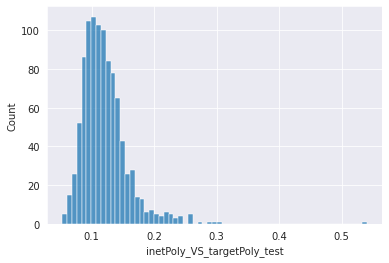

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

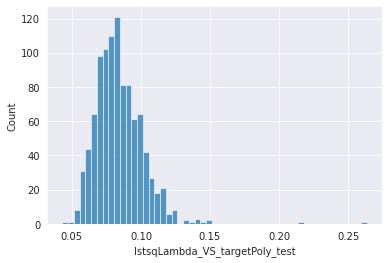

In [36]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

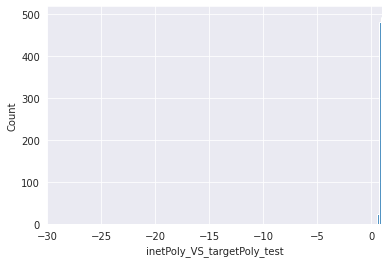

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

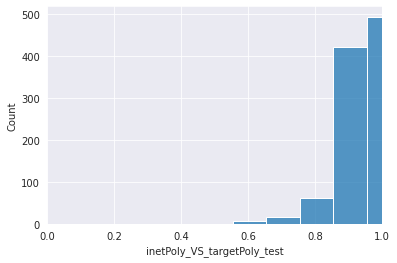

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

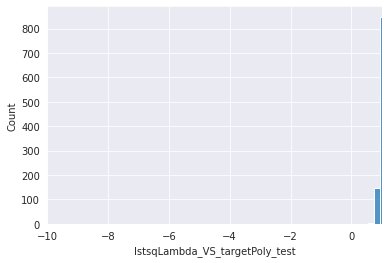

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

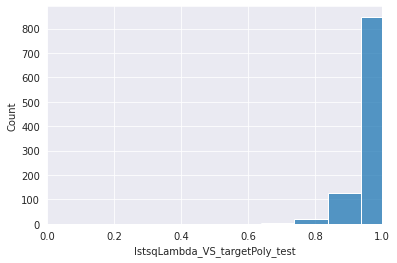

In [40]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [42]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [45]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [46]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


-0.2766*a**1.0*b**1.0*c**1.0 - 0.551*a**1.0*b**1.0*c**2.0 - 0.6562*a**1.0*b**1.0*c**3.0 + 0.2147*a**1.0*b**1.0 - 0.4148*a**1.0*b**2.0*c**1.0 + 0.0775*a**1.0*b**2.0*c**2.0 - 0.3452*a**1.0*b**2.0 + 0.7482*a**1.0*b**3.0*c**1.0 + 0.0031*a**1.0*b**3.0 - 0.2946*a**1.0*b**4.0 + 0.02*a**1.0*c**1.0 - 0.1999*a**1.0*c**2.0 + 0.6372*a**1.0*c**3.0 + 0.651*a**1.0*c**4.0 - 0.7997*a**1.0 - 0.2891*a**2.0*b**1.0*c**1.0 - 0.0084*a**2.0*b**1.0*c**2.0 - 0.0879*a**2.0*b**1.0 - 0.0743*a**2.0*b**2.0*c**1.0 + 0.9381*a**2.0*b**2.0 - 0.1577*a**2.0*b**3.0 - 0.4365*a**2.0*c**1.0 + 0.2178*a**2.0*c**2.0 - 0.0067*a**2.0*c**3.0 - 0.7931*a**2.0 - 0.4225*a**3.0*b**1.0*c**1.0 + 0.0696*a**3.0*b**1.0 + 0.5774*a**3.0*b**2.0 + 0.2893*a**3.0*c**1.0 + 0.2689*a**3.0*c**2.0 + 0.6333*a**3.0 - 0.8599*a**4.0*b**1.0 - 0.0115*a**4.0*c**1.0 - 0.7781*a**4.0 - 0.5091*a**5.0 - 0.3278*b**1.0*c**1.0 - 0.8931*b**1.0*c**2.0 + 0.9612*b**1.0*c**3.0 + 0.5858*b**1.0*c**4.0 + 0.9776*b**1.0 - 0.2513*b**2.0*c**1.0 + 0.5147*b**2.0*c**2.0 + 0.739*b**

LSTSQ Target Poly:


0.6397*a**1.0*b**1.0*c**1.0 + 0.1775*a**1.0*b**1.0*c**2.0 + 2.7228*a**1.0*b**1.0*c**3.0 - 2.1044*a**1.0*b**1.0 - 2.6286*a**1.0*b**2.0*c**1.0 - 2.8106*a**1.0*b**2.0*c**2.0 - 0.4214*a**1.0*b**2.0 + 5.8723*a**1.0*b**3.0*c**1.0 + 2.1787*a**1.0*b**3.0 - 3.2406*a**1.0*b**4.0 + 2.1997*a**1.0*c**1.0 - 0.5289*a**1.0*c**2.0 + 0.7332*a**1.0*c**3.0 - 1.363*a**1.0*c**4.0 + 0.037*a**1.0 - 7.5943*a**2.0*b**1.0*c**1.0 - 1.4191*a**2.0*b**1.0*c**2.0 + 3.112*a**2.0*b**1.0 - 2.2461*a**2.0*b**2.0*c**1.0 + 0.5316*a**2.0*b**2.0 + 2.9743*a**2.0*b**3.0 - 5.8933*a**2.0*c**1.0 + 3.2801*a**2.0*c**2.0 + 0.6858*a**2.0*c**3.0 - 3.0365*a**2.0 + 7.3409*a**3.0*b**1.0*c**1.0 + 1.9464*a**3.0*b**1.0 - 2.6159*a**3.0*b**2.0 + 7.4937*a**3.0*c**1.0 - 2.3458*a**3.0*c**2.0 + 6.3477*a**3.0 - 2.9598*a**4.0*b**1.0 - 3.7296*a**4.0*c**1.0 - 12.4332*a**4.0 + 7.1187*a**5.0 + 1.2875*b**1.0*c**1.0 - 1.7555*b**1.0*c**2.0 + 0.1723*b**1.0*c**3.0 + 0.0193*b**1.0*c**4.0 + 0.5761*b**1.0 - 0.9251*b**2.0*c**1.0 + 3.745*b**2.0*c**2.0 - 1.4055*b*

LSTSQ Lambda Poly:


0.6397*a**1.0*b**1.0*c**1.0 + 0.1775*a**1.0*b**1.0*c**2.0 + 2.7228*a**1.0*b**1.0*c**3.0 - 2.1044*a**1.0*b**1.0 - 2.6286*a**1.0*b**2.0*c**1.0 - 2.8106*a**1.0*b**2.0*c**2.0 - 0.4214*a**1.0*b**2.0 + 5.8723*a**1.0*b**3.0*c**1.0 + 2.1787*a**1.0*b**3.0 - 3.2406*a**1.0*b**4.0 + 2.1997*a**1.0*c**1.0 - 0.5289*a**1.0*c**2.0 + 0.7332*a**1.0*c**3.0 - 1.363*a**1.0*c**4.0 + 0.037*a**1.0 - 7.5943*a**2.0*b**1.0*c**1.0 - 1.4191*a**2.0*b**1.0*c**2.0 + 3.112*a**2.0*b**1.0 - 2.2461*a**2.0*b**2.0*c**1.0 + 0.5316*a**2.0*b**2.0 + 2.9743*a**2.0*b**3.0 - 5.8933*a**2.0*c**1.0 + 3.2801*a**2.0*c**2.0 + 0.6858*a**2.0*c**3.0 - 3.0365*a**2.0 + 7.3409*a**3.0*b**1.0*c**1.0 + 1.9464*a**3.0*b**1.0 - 2.6159*a**3.0*b**2.0 + 7.4937*a**3.0*c**1.0 - 2.3458*a**3.0*c**2.0 + 6.3477*a**3.0 - 2.9598*a**4.0*b**1.0 - 3.7296*a**4.0*c**1.0 - 12.4332*a**4.0 + 7.1187*a**5.0 + 1.2875*b**1.0*c**1.0 - 1.7555*b**1.0*c**2.0 + 0.1723*b**1.0*c**3.0 + 0.0193*b**1.0*c**4.0 + 0.5761*b**1.0 - 0.9251*b**2.0*c**1.0 + 3.745*b**2.0*c**2.0 - 1.4055*b*

I-Net Poly:


-0.0626000016927719*a**1.0*b**1.0*c**1.0 + 0.00410000002011657*a**1.0*b**1.0*c**2.0 + 0.130500003695488*a**1.0*b**1.0*c**3.0 - 0.0412000007927418*a**1.0*b**1.0 - 0.252600014209747*a**1.0*b**2.0*c**1.0 + 0.049600001424551*a**1.0*b**2.0*c**2.0 - 0.230199992656708*a**1.0*b**2.0 + 0.205099999904633*a**1.0*b**3.0*c**1.0 - 0.0738999992609024*a**1.0*b**3.0 + 0.232199996709824*a**1.0*b**4.0 + 0.259799987077713*a**1.0*c**1.0 - 0.199799999594688*a**1.0*c**2.0 - 0.0631000027060509*a**1.0*c**3.0 + 0.0970999971032143*a**1.0*c**4.0 - 0.206000000238419*a**1.0 - 0.25229999423027*a**2.0*b**1.0*c**1.0 - 0.094700001180172*a**2.0*b**1.0*c**2.0 - 0.373100012540817*a**2.0*b**1.0 - 0.0548000000417233*a**2.0*b**2.0*c**1.0 - 0.17620000243187*a**2.0*b**2.0 + 0.212400004267693*a**2.0*b**3.0 - 0.160799995064735*a**2.0*c**1.0 + 0.0943000018596649*a**2.0*c**2.0 + 0.256599992513657*a**2.0*c**3.0 - 0.541800022125244*a**2.0 - 0.235400006175041*a**3.0*b**1.0*c**1.0 - 0.214800000190735*a**3.0*b**1.0 + 0.100900001823902*

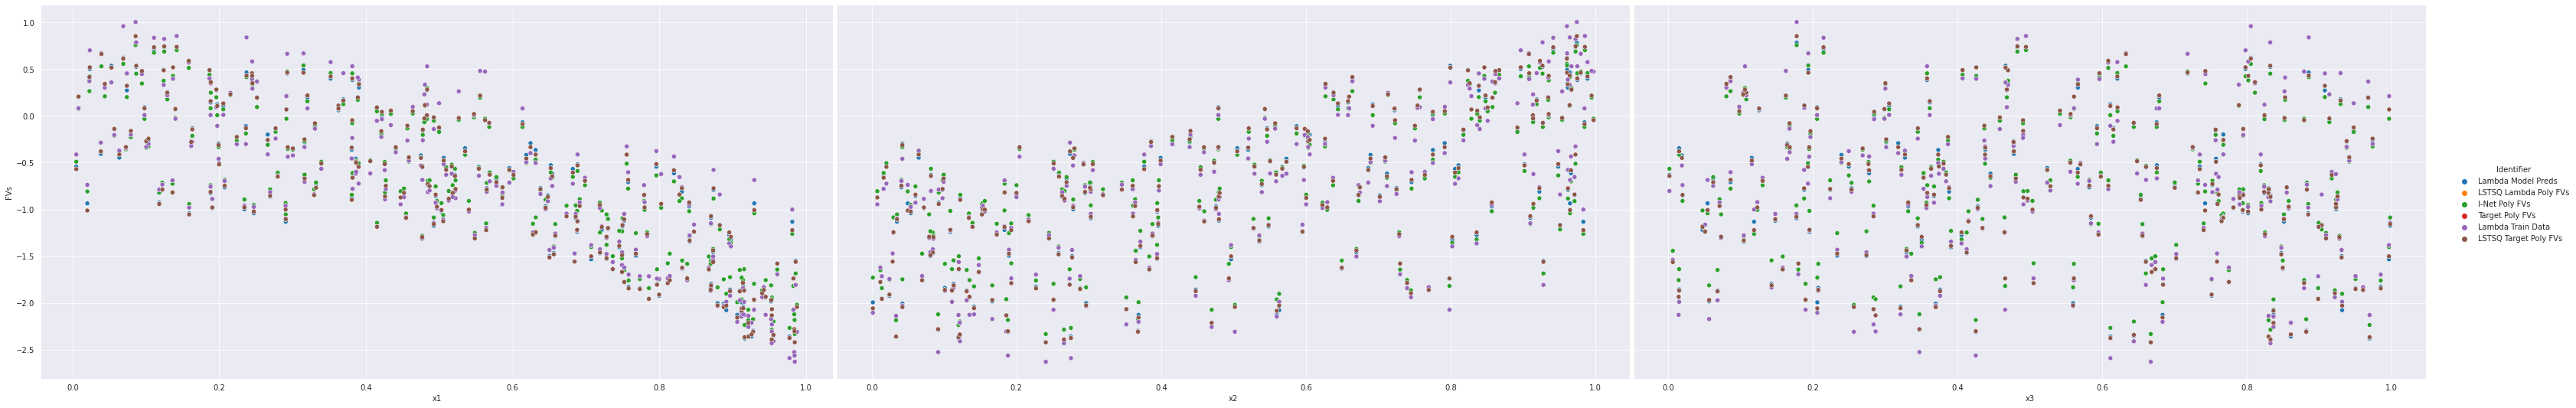

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.016404138076144756 | 0.9992842577368077 |   -    |           0.6397*a**1.0*b**1.0*c**1.0 +            |
|            vs.            |                      |                    |        |           0.1775*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 2.7228*a**1.0*b**1.0*c**3.0 - 2.1044*a**1.0*b**1.0 |
|                           |                      |                    |        |          - 2.6286*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

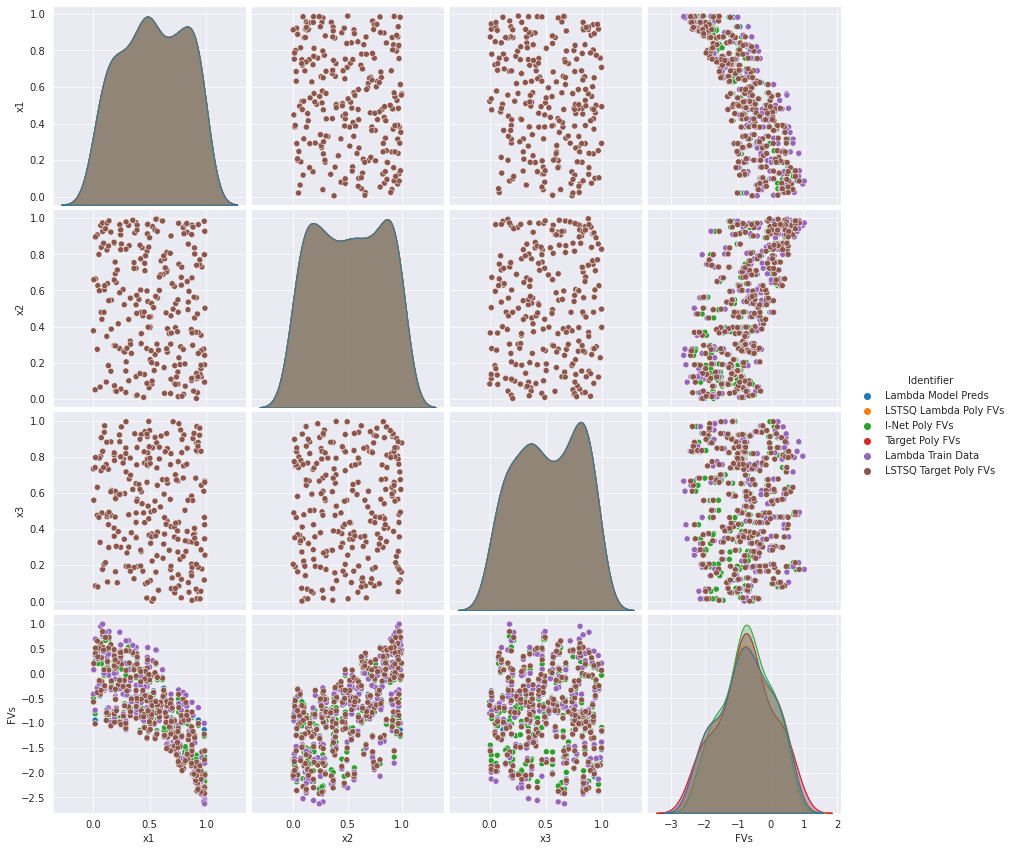

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.016404138076144756 | 0.9992842577368077 |   -    |           0.6397*a**1.0*b**1.0*c**1.0 +            |
|            vs.            |                      |                    |        |           0.1775*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 2.7228*a**1.0*b**1.0*c**3.0 - 2.1044*a**1.0*b**1.0 |
|                           |                      |                    |        |          - 2.6286*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

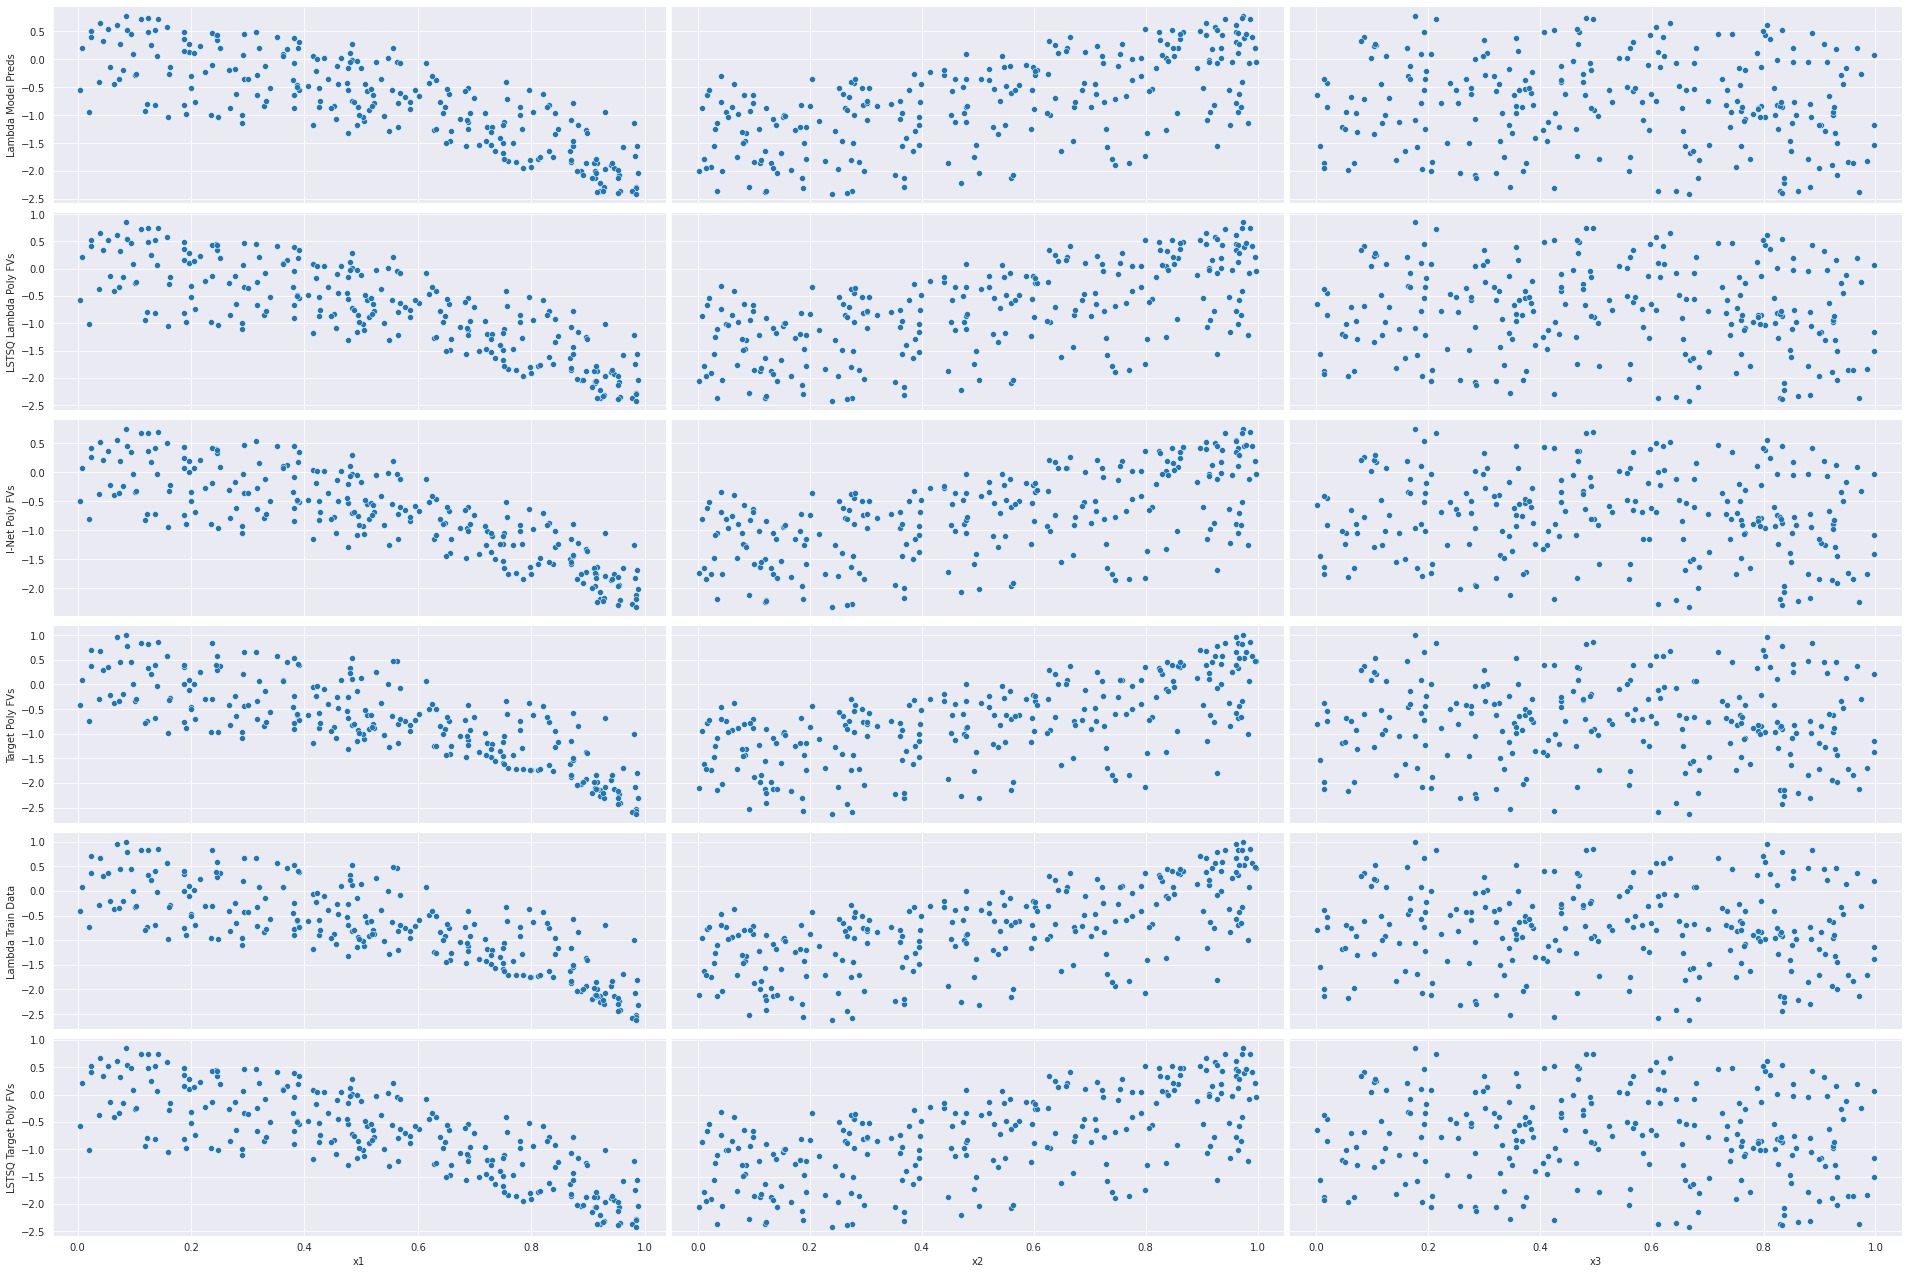

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.016404138076144756 | 0.9992842577368077 |   -    |           0.6397*a**1.0*b**1.0*c**1.0 +            |
|            vs.            |                      |                    |        |           0.1775*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 2.7228*a**1.0*b**1.0*c**3.0 - 2.1044*a**1.0*b**1.0 |
|                           |                      |                    |        |          - 2.6286*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [50]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [51]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

In [52]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0086


In [53]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 9.9791


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [54]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [55]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 1.0035


In [56]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [57]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()